In [1]:
# import warnings filter
from warnings import simplefilter
import warnings
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import numpy as np
import ast
from itertools import combinations, product
from sklearn import manifold
import matplotlib.pyplot as plt

In [3]:
df = pd.read_csv("output_combined_location.csv")

In [4]:
#Get the tweets
#Get the frequency of the countries mentioned
df.head()

,id,username,text,retweets,favorites,replies,permalink,date,mentions,hashtags,Tweet_Token,Tweet_Location_Found
0,1200516560160481280,vanderfullife,Pan Pacific Airlines adds Clark – Muan route f...,0,0,0,https://twitter.com/vanderfullife/status/12005...,2019-11-29 20:47:07+00:00,NaN,#news #today #travel #vacation #cruise #holida...,"['Pan', 'Pacific', 'Airlines', 'adds', 'Clark'...",['pan']
1,1200516487389122560,sweetsteph0914,Today I was presented w/ an #eviction notice (...,0,0,0,https://twitter.com/sweetsteph0914/status/1200...,2019-11-29 20:46:49+00:00,@Twitter,#eviction #holidays,"['Today', 'I', 'was', 'presented', 'w', '/', '...","['at', 'can', 'me', 'my', 'to']"
2,1200516453612568576,PhilMorseRE,Earning extra money during the #holidays can m...,0,0,0,https://twitter.com/PhilMorseRE/status/1200516...,2019-11-29 20:46:41+00:00,NaN,#holidays #creditcards,"['Earning', 'extra', 'money', 'during', 'the',...","['can', 'it', 'to']"
3,1200516306967154688,HollyNorth,"Oh the weather outside is frightful, and our s...",0,0,0,https://twitter.com/HollyNorth/status/12005163...,2019-11-29 20:46:06+00:00,NaN,#Holidays #HollyNorth #HollyNorthProductionSup...,"['Oh', 'the', 'weather', 'outside', 'is', 'fri...","['and', 'is', 'it', 'so']"
4,1200516102205239296,LissaandTiniRay,Hanging with some of my favs @CranbrookLiquo1 ...,0,0,0,https://twitter.com/LissaandTiniRay/status/120...,2019-11-29 20:45:17+00:00,@CranbrookLiquo1,#g4tequila #liquorstores #tastings #lovethiscr...,"['Hanging', 'with', 'some', 'of', 'my', 'favs'...","['and', 'my']"


In [5]:
no_null_values = df["Tweet_Location_Found"].dropna()

In [6]:
destinations = df.iloc[no_null_values.index]

In [7]:
def convert_to_array(val):
    str1 = val.replace(']','').replace('[','')
    l = str1.split(",")
    return l

In [8]:
destinations["Tweet_Location_Found"] = destinations["Tweet_Location_Found"].apply(lambda x: convert_to_array(x))

In [9]:
def word_freq(word_list):
    word_map = {}
    for a in word_list:
        for word in a:
            word = word.strip()
            if word in word_map:
                word_map[word] += 1
            else:
                word_map.update({word : 1})
    return sorted(word_map.items(), key=lambda kv: kv[1],reverse=True)

In [10]:
word_freq(destinations["Tweet_Location_Found"])

[("'to'", 5009),
 ("'and'", 4042),
 ("'in'", 3461),
 ("'is'", 2183),
 ("'at'", 1773),
 ("'are'", 1162),
 ("'it'", 1118),
 ("'us'", 866),
 ("'be'", 865),
 ("'by'", 736),
 ("'my'", 714),
 ("'can'", 665),
 ("'so'", 478),
 ("'do'", 426),
 ("'central'", 400),
 ("'as'", 394),
 ("'has'", 366),
 ("'me'", 332),
 ("'no'", 323),
 ("'de'", 261),
 ("'most'", 253),
 ("'northern'", 246),
 ("'south'", 238),
 ("'scotland'", 214),
 ("'western'", 189),
 ("'la'", 184),
 ("'est'", 138),
 ("'florida'", 134),
 ("'york'", 127),
 ("'am'", 123),
 ("'north'", 114),
 ("'re'", 108),
 ("'com'", 98),
 ("'pk'", 94),
 ("'eastern'", 90),
 ("'turkey'", 85),
 ("'spain'", 84),
 ("'bali'", 82),
 ("'lot'", 81),
 ("'centre'", 78),
 ("'st'", 75),
 ("'et'", 75),
 ("'pool'", 72),
 ("'italy'", 67),
 ("'california'", 64),
 ("'india'", 60),
 ("'mexico'", 57),
 ("'east'", 56),
 ("'paris'", 56),
 ("'ve'", 55),
 ("'bay'", 54),
 ("'manchester'", 54),
 ("'france'", 52),
 ("'west'", 51),
 ("'jamaica'", 51),
 ("'per'", 50),
 ("'australia

In [11]:
top_10_destinations = ["scotland","la","florida","york","turkey","spain","bali","italy","california","india"]

In [12]:
# Calculation of lift scores. Code Gotten from project 1
def do_lift(x, y=None):
    l1, l2 = sorted(x), sorted(y or [])
    bools = pd.DataFrame()
    for e in l1 + l2:
        bools[e] = destinations['Tweet_Token'].map(lambda words: e in words)

    def do(df, a, b):
        count_a_int_b = np.logical_and(df[a], df[b]).values.sum()
        count_a_mult_count_b = df[a].values.sum() * df[b].values.sum()
        return len(df.index) * count_a_int_b / count_a_mult_count_b

    result_df = pd.DataFrame(index=l1, columns=(l2 or l1))
    for a, b in (combinations(l1, 2) if y==None else product(l1, l2)):
        val = do(bools, a, b)
        result_df.at[a, b] = val
        if y==None:
            result_df.at[b, a] = val

    return result_df

In [13]:
top_destinations = do_lift(top_10_destinations)
topDestinationsList = list(top_destinations.columns)

In [14]:
#Lets take care of the 0 scores by padding the lift values by 0.5
floatdf = top_destinations.astype(float)
floatdf = floatdf.add(0.5)
np.fill_diagonal(floatdf.values, 0)
floatdf

,bali,california,florida,india,italy,la,scotland,spain,turkey,york
bali,0.000000,0.500000,0.500000,10.915895,0.500000,1.775206,0.500000,0.500000,0.500000,0.500000
california,0.500000,0.000000,0.500000,3.540315,0.500000,1.640681,0.500000,0.500000,0.500000,0.500000
florida,0.500000,0.500000,0.000000,1.823431,4.373458,1.702130,0.500000,0.500000,1.521298,0.500000
india,10.915895,3.540315,1.823431,0.000000,0.500000,1.647685,0.500000,0.500000,0.500000,0.500000
italy,0.500000,0.500000,4.373458,0.500000,0.000000,1.800289,1.303034,0.500000,0.500000,2.507585
la,1.775206,1.640681,1.702130,1.647685,1.800289,0.000000,2.721326,1.725559,1.207110,0.960519
scotland,0.500000,0.500000,0.500000,0.500000,1.303034,2.721326,0.000000,0.500000,0.500000,0.500000
spain,0.500000,0.500000,0.500000,0.500000,0.500000,1.725559,0.500000,0.000000,0.500000,0.500000
turkey,0.500000,0.500000,1.521298,0.500000,0.500000,1.207110,0.500000,0.500000,0.000000,1.029331
york,0.500000,0.500000,0.500000,0.500000,2.507585,0.960519,0.500000,0.500000,1.029331,0.000000


In [15]:
dissimilarity_matrix = (1/floatdf).astype(float)
np.fill_diagonal(dissimilarity_matrix.values, 0)
dissimilarity_matrix

,bali,california,florida,india,italy,la,scotland,spain,turkey,york
bali,0.000000,2.000000,2.000000,0.091610,2.000000,0.563315,2.000000,2.000000,2.000000,2.000000
california,2.000000,0.000000,2.000000,0.282461,2.000000,0.609503,2.000000,2.000000,2.000000,2.000000
florida,2.000000,2.000000,0.000000,0.548417,0.228652,0.587499,2.000000,2.000000,0.657334,2.000000
india,0.091610,0.282461,0.548417,0.000000,2.000000,0.606912,2.000000,2.000000,2.000000,2.000000
italy,2.000000,2.000000,0.228652,2.000000,0.000000,0.555467,0.767440,2.000000,2.000000,0.398790
la,0.563315,0.609503,0.587499,0.606912,0.555467,0.000000,0.367468,0.579522,0.828425,1.041104
scotland,2.000000,2.000000,2.000000,2.000000,0.767440,0.367468,0.000000,2.000000,2.000000,2.000000
spain,2.000000,2.000000,2.000000,2.000000,2.000000,0.579522,2.000000,0.000000,2.000000,2.000000
turkey,2.000000,2.000000,0.657334,2.000000,2.000000,0.828425,2.000000,2.000000,0.000000,0.971505
york,2.000000,2.000000,2.000000,2.000000,0.398790,1.041104,2.000000,2.000000,0.971505,0.000000


In [16]:
# Plotting MDS plot
seed = np.random.RandomState(seed=3)
mds = manifold.MDS(n_components=2, max_iter=3000, eps=1e-9, 
      random_state=seed, dissimilarity="precomputed", n_jobs=1)
results = mds.fit(dissimilarity_matrix)
coords = results.embedding_

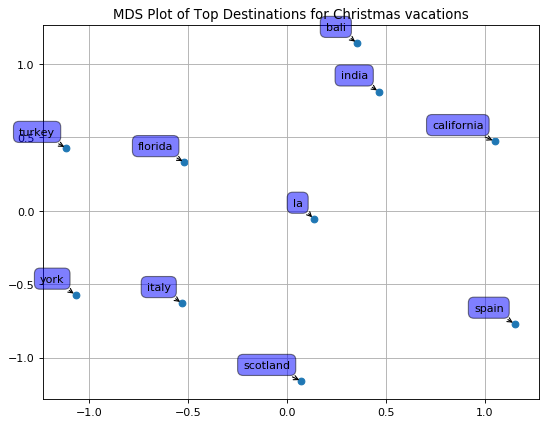

In [17]:
plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
plt.subplots_adjust(bottom = 0.1)
plt.scatter(coords[:, 0], coords[:, 1], marker = 'o')

for label, x, y in zip(topDestinationsList, coords[:, 0], coords[:, 1]):
    plt.annotate(
        label,
        xy = (x, y), xytext = (-10, 10),
        textcoords = 'offset points', ha = 'right', va = 'bottom',
        bbox = dict(boxstyle = 'round,pad=0.5', fc = 'blue', alpha = 0.5),
        arrowprops = dict(arrowstyle = '->', connectionstyle = 'arc3,rad=0'))
plt.title('MDS Plot of Top Destinations for Christmas vacations')
plt.grid()
plt.show()